In [1]:
import spacy
from collections import Counter
import tomotopy as tp
import os
from tqdm import tqdm
import pandas
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import random

## Prepare data

In [2]:
# Load german model
nlp = spacy.load('de_core_news_lg')

In [3]:
custom_stopwords = ['B.', '$', 'Fig', 'z.', 'MATH', '=', "S."]

In [4]:
for c in custom_stopwords:
    nlp.vocab[c].is_stop = True

In [5]:
# Parse files
file_list = []
for file in os.listdir('data/all_txt/'):
    file_list.append(file)

In [6]:
# Create a dictionary of all lemmatized texts
texts = dict()
for file in tqdm(file_list):
    with open(f'data/all_txt/{file}', 'r', encoding='utf-8') as f:
        text = f.read()
        text = text.replace('¬\n', '')
        doc = nlp(text)
        name = file.split('.')[0]
        
        texts[name] = doc
        

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:34<00:00, 19.32s/it]


## Basic statistics

In [7]:
entries = []
for name, txt in texts.items():
    words = [token.text
         for token in txt
         if not token.is_stop and not token.is_punct and not token.is_space]
    nouns = [token.text
         for token in txt
         if (not token.is_stop and
             not token.is_punct and
             token.pos_ == "NOUN")]
    vocab = set(words)
    
    # most common tokens
    word_freq = Counter(words)
    common_words = word_freq.most_common(10)

    # most common noun tokens
    noun_freq = Counter(nouns)
    common_nouns = noun_freq.most_common(10)

    # vocabulary size
    vocab_size = len(vocab)
    
    entry = {
        'name': name,
        'common words': common_words,
        'common nouns': common_nouns,
        'vocabulary size': vocab_size,
    }
    
    entries.append(entry)
    

In [8]:
glob_words = []
glob_nouns = []

for name, txt in texts.items():
    for token in txt:
        if not token.is_stop and not token.is_punct and not token.is_space:
            glob_words.append(token.text)
        if (not token.is_stop and not token.is_punct and token.pos_ == "NOUN"):
            glob_nouns.append(token.text)

glob_vocab = set(glob_words)

# most common tokens
word_freq = Counter(glob_words)
glob_common_words = word_freq.most_common(10)

# most common noun tokens
noun_freq = Counter(glob_nouns)
glob_common_nouns = noun_freq.most_common(10)

# vocabulary size
glob_vocab_size = len(glob_vocab)

glob_entry = {
    'name': 'all texts',
    'common words': glob_common_words,
    'common nouns': glob_common_nouns,
    'vocabulary size': glob_vocab_size,
}

entries.append(glob_entry)


In [9]:
glob_entry

{'name': 'all texts',
 'common words': [('Töne', 662),
  ('c', 605),
  ('e', 543),
  ('Terz', 476),
  ('g', 450),
  ('Ton', 436),
  ('C', 435),
  ('Folge', 407),
  ('Bedeutung', 406),
  ('h', 400)],
 'common nouns': [('Töne', 662),
  ('Terz', 439),
  ('Ton', 435),
  ('Folge', 407),
  ('Bedeutung', 406),
  ('Tonart', 352),
  ('Grundton', 348),
  ('Accorde', 282),
  ('Dissonanz', 254),
  ('Dreiklang', 240)],
 'vocabulary size': 19569}

In [10]:
df = pandas.DataFrame(data=entries)
df

,name,common words,common nouns,vocabulary size
0,CAP1905,"[(c, 161), (e, 159), (g, 128), (C, 122), (Riem...","[(Terz, 52), (Grundton, 51), (Töne, 47), (Auff...",4914
1,HAU1853,"[(Quint, 305), (Terz, 254), (Folge, 249), (Bed...","[(Folge, 249), (Bedeutung, 235), (Terz, 233), ...",7904
2,KUN1863,"[(2c, 85), (Verfasser, 83), (Töne, 76), (Seite...","[(2c, 85), (Verfasser, 83), (Töne, 76), (Seite...",5314
3,NAU1858,"[(Töne, 110), (Terz, 63), (gr, 58), (C, 58), (...","[(Töne, 110), (Terz, 63), (Quinte, 46), (Octav...",2750
4,OET1866,"[(c, 341), (1, 255), (g, 255), (e, 230), (d, 2...","[(Töne, 189), (Ton, 145), (Klänge, 144), (Verw...",6780
5,RIE1905,"[(Töne, 38), (Konsonanz, 30), (Ton, 28), (Terz...","[(Töne, 38), (Konsonanz, 30), (Ton, 28), (Terz...",2328
6,WEI1860,"[(C, 55), (Tonart, 47), (Töne, 46), (folgenden...","[(Tonart, 47), (Töne, 46), (Quinte, 34), (Acco...",1860
7,WEI1861,"[(Tonart, 30), (Herr, 25), (Schrift, 22), (Kri...","[(Tonart, 30), (Herr, 25), (Schrift, 22), (Kri...",1726
8,all texts,"[(Töne, 662), (c, 605), (e, 543), (Terz, 476),...","[(Töne, 662), (Terz, 439), (Ton, 435), (Folge,...",19569


In [11]:
df.to_csv('text_stats.csv', encoding='utf-8')

## Topic modeling

In [42]:
mdl = tp.LDAModel(k=5)

In [43]:
for txt in texts.values():
    words = [token.text
         for token in txt
         if not token.is_stop and not token.is_punct and not token.is_space]
    for i in range(0,len(words),100):
        mdl.add_doc(words[i: i+100])

In [44]:
mdl.train(500)

In [45]:
mdl.save('topmodel.bin', full=False)

### pyLDAvis

In [107]:
import pyLDAvis
import numpy as np 
import warnings

topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq

prepared_data = pyLDAvis.prepare(
    topic_term_dists,
    doc_topic_dists,
    doc_lengths,
    vocab,
    term_frequency,
    sort_topics=False,
    start_index=1,
)



In [108]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pyLDAvis.save_html(prepared_data, "ldavis.html")
    
    pyLDAvis.enable_notebook()
    

In [109]:
pyLDAvis.display(prepared_data)

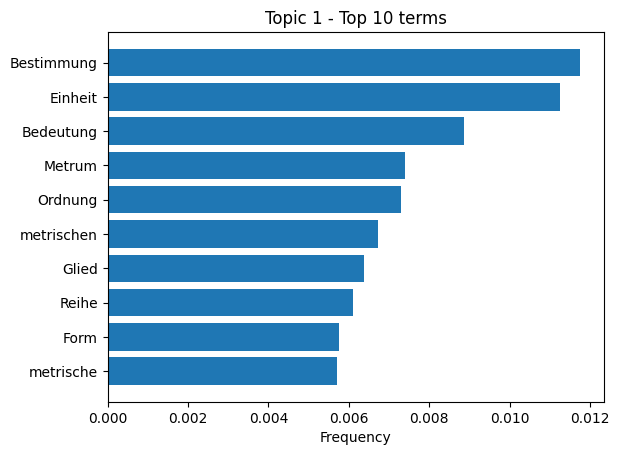

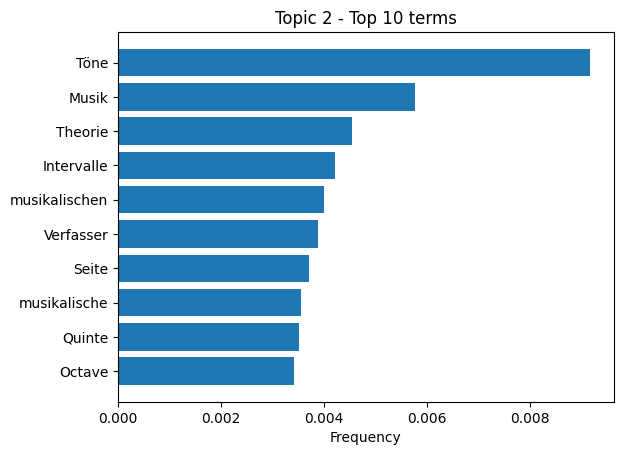

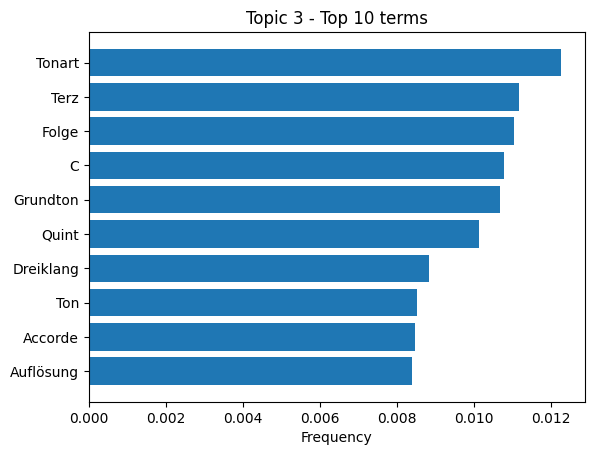

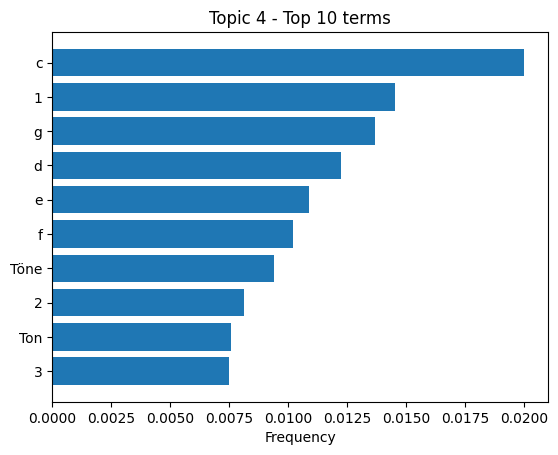

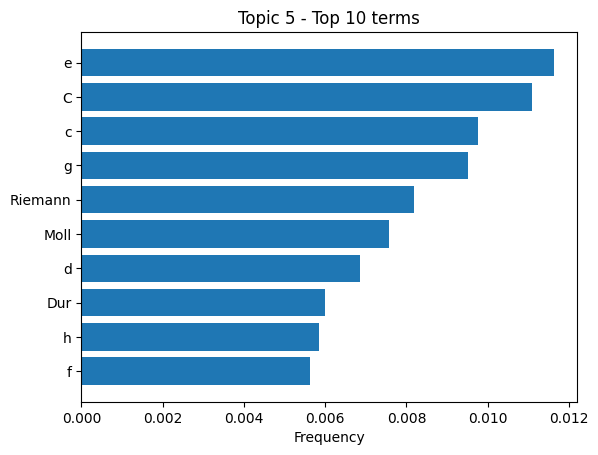

In [110]:
# Plot and save most common terms along topics

for i in range(5):
    terms = []
    scores = []
    for name, score in mdl.get_topic_words(i, top_n=10):
        terms.append(name)
        scores.append(score)

    y_pos = np.arange(len(terms))

    plt.rcdefaults()
    fig, ax = plt.subplots()


    ax.barh(y_pos, scores, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(terms)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Frequency')
    ax.set_title(f'Topic {i+1} - Top 10 terms')

    plt.show()

    fig.savefig(f'topic{i+1}.png')

In [111]:
cols = [k for k in range(5)]
idx = [str(i) for i in range(10)]

top10 = pandas.DataFrame(index=idx, columns=cols)

for k in range(5):   
    top10[k] = [word + f" ({round(freq*100, 3)} %)" for word, freq in mdl.get_topic_words(k)]
    
top10.columns = [f"Topic {c + 1}" for c in top10.columns]

In [112]:
top10

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,Bestimmung (1.175 %),Töne (0.917 %),Tonart (1.227 %),c (2.002 %),e (1.163 %)
1,Einheit (1.125 %),Musik (0.576 %),Terz (1.117 %),1 (1.452 %),C (1.108 %)
2,Bedeutung (0.887 %),Theorie (0.455 %),Folge (1.106 %),g (1.368 %),c (0.975 %)
3,Metrum (0.74 %),Intervalle (0.422 %),C (1.08 %),d (1.226 %),g (0.952 %)
4,Ordnung (0.729 %),musikalischen (0.4 %),Grundton (1.069 %),e (1.089 %),Riemann (0.819 %)
5,metrischen (0.672 %),Verfasser (0.389 %),Quint (1.013 %),f (1.022 %),Moll (0.757 %)
6,Glied (0.639 %),Seite (0.371 %),Dreiklang (0.884 %),Töne (0.939 %),d (0.687 %)
7,Reihe (0.61 %),musikalische (0.356 %),Ton (0.851 %),2 (0.813 %),Dur (0.601 %)
8,Form (0.576 %),Quinte (0.352 %),Accorde (0.848 %),Ton (0.759 %),h (0.585 %)
9,metrische (0.571 %),Octave (0.341 %),Auflösung (0.84 %),3 (0.751 %),f (0.562 %)


In [113]:
top10.to_latex("top10.tex", index=False)

In [114]:
topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq

In [115]:
pca = PCA(n_components=2)
#pca = MDS(n_components=2)
X = pca.fit_transform(topic_term_dists)

In [116]:
coherence = tp.coherence.Coherence(mdl)

In [117]:
warnings.filterwarnings("ignore")

In [119]:
sizes = [np.exp(coherence.get_score(topic_id=i))*5000 for i in range(5)]

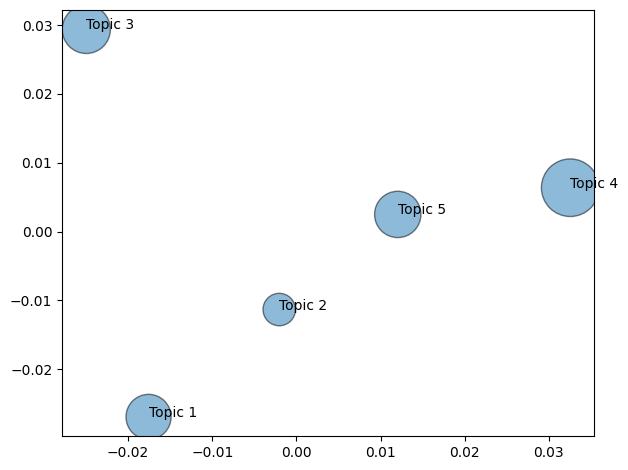

In [120]:
plt.scatter(X[:,0], X[:,1], s=sizes, edgecolor="k", alpha=.5)

for i in range(5):
    plt.annotate(f"Topic {i+1}", (X[:,0][i], X[:,1][i]))

plt.tight_layout()
plt.savefig('topics.png')

In [121]:
topic_dist = []
for file in file_list:
    words = [token.text
         for token in texts[file.split('.')[0]]
         if not token.is_stop and not token.is_punct and not token.is_space]
    subset = list(words)
    random.shuffle(subset)
    subset = subset[:1000]
    d = mdl.make_doc(subset)
    scores = mdl.infer(d, iter=100)
    
    new_entry = {
        'name': file.split('.')[0],
    }
    
    for i in range(5):
        new_entry[f'topic_{i}'] = round(scores[0][i]*100, 3)
    
    topic_dist.append(new_entry)

In [122]:
dist_df = pandas.DataFrame(data=topic_dist)
dist_df

,name,topic_0,topic_1,topic_2,topic_3,topic_4
0,CAP1905,2.027,16.618,8.036,11.423,61.897
1,HAU1853,41.450,7.735,46.262,4.137,0.415
2,KUN1863,2.925,68.019,17.517,9.726,1.813
3,NAU1858,3.923,56.841,22.308,14.717,2.212
4,OET1866,5.819,14.622,9.134,65.419,5.006
5,RIE1905,5.719,26.100,5.141,11.622,51.417
6,WEI1860,3.424,35.382,53.548,6.632,1.014
7,WEI1861,1.627,61.731,23.506,10.125,3.010


In [123]:
dist_df.to_latex("topicrepartition.tex", index=False)

## Document vectors

In [124]:
vectorizer = TfidfVectorizer()

In [ ]:
raw_texts = []
for file in file_list:
    with open(f'data/all_txt/{file}', 'r', encoding='utf-8') as f:
        raw = f.read()
        raw = raw.replace('¬\n', '')
        
        raw_texts.append(raw)

In [ ]:
Y = vectorizer.fit_transform(raw_texts).todense()

In [ ]:
pca = PCA(n_components=2).fit(Y)
data2D = pca.transform(Y)


In [ ]:
text_lengths = [ len(t)/100 for t in raw_texts ]

In [ ]:
plt.scatter(data2D[:,0], data2D[:,1], s=text_lengths, edgecolor="k", alpha=.5)
for i in range(8):
    plt.annotate(file_list[i].split('.')[0], (data2D[:,0][i], data2D[:,1][i]))
    
plt.tight_layout()
plt.savefig('tfidf.png')

- 2 Figures
    1. PCA/MDS of document vectors (TF-IDF)
    2. PCA/MDS of topic-term dists 
    3. Table of top 10 words for topics